# Dog Breed Identification
This notebook uses transfer learning to build a Multi-Class Image Classifier using TensorFlow 2.x and TensorFlow Hub.

## 1. Problem

We are provided with a training set and a test set of images of dogs. Each image has a filename that is its unique id. The dataset comprises 120 breeds of dogs. The goal is to create a classifier capable of determining a dog's breed from a photo.

## 2. Data

The data we're using is from Kaggle's dog breed identification competition.

https://www.kaggle.com/c/dog-breed-identification/data 

## 3. Evaluation

The evaluation is a file with prediction probabilities for each dog breed of each test image.

https://www.kaggle.com/c/dog-breed-identification/overview/evaluation

## 4. Features
* There are 120 breeds of dogs (this means there are 120 different classes).
* There are around 10,222 images in the training set (these images have labels.
* There are around 10,222 images in the test set (these images have no labels, because we'll want to predict them).

### Getting the Data and Importing the Libraries
We will start of by getting the data from Kaggle, using the Kaggle api but will do a pip "force install" first in order to prevent any errors. 

In [1]:
!pip install --upgrade --force-reinstall --no-deps kaggle

     |████████████████████████████████| 61kB 8.6MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.10-cp36-none-any.whl size=73269 sha256=a0ba8db72ed1d779f815612fe0aa41d2f8a829c20f3809522b969f5a78dd3ef5
  Stored in directory: /root/.cache/pip/wheels/3a/d1/7e/6ce09b72b770149802c653a02783821629146983ee5a360f10
Successfully built kaggle
  Found existing installation: kaggle 1.5.10
    Uninstalling kaggle-1.5.10:
      Successfully uninstalled kaggle-1.5.10


In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from keras.utils import to_categorical
import tensorflow as tf
import tensorflow_hub as hub
print(tf.__version__) #Make sure Tensorflow 2 is imported

2.4.0


In [3]:
# Adding the Username and Key from the Kaggle Token Folder
os.environ['KAGGLE_USERNAME']="hassanjoumaa"
os.environ['KAGGLE_KEY']="5e66163ab8d43def76ee3643557bea64"

In [4]:
# Downloading the Dataset from Kaggle
!kaggle competitions download -c dog-breed-identification

100% 691M/691M [00:02<00:00, 209MB/s]
100% 691M/691M [00:02<00:00, 268MB/s]


In [5]:
# Unziping the Folder
!unzip dog-breed-identification.zip

Streaming output truncated to the last 5000 lines.
  inflating: train/83bc62b0fffa99a9c94ba0b67a5f7395.jpg  
  inflating: train/83bcff6b55ee179a7c123fa6103c377a.jpg  
  inflating: train/83be6d622ab74a5e7e08b53eb8fd566a.jpg  
  inflating: train/83c2d7419b0429b9fe953bc1b6cddbec.jpg  
  inflating: train/83cf7d7cd2a759a93e2ffd95bea9c6fb.jpg  
  inflating: train/83d405858f0931722ef21e8ac0adee4d.jpg  
  inflating: train/83d4125a4c3c7dc5956563276cb1cd74.jpg  
  inflating: train/83f0bb565b2186dbcc6a9d009cb26ff2.jpg  
  inflating: train/83fad0718581a696132c96c166472627.jpg  
  inflating: train/83fbbcc9a612e3f712b1ba199da61f20.jpg  
  inflating: train/8403d8936430c2f05ab7d74d23c2c0cb.jpg  
  inflating: train/8406d837b2d7fac1c3cd621abb4c4f9e.jpg  
  inflating: train/840b67d26e5e43f8eb6430f62d4ba1ac.jpg  
  inflating: train/840db91ba4600148f3dcb06ec419b421.jpg  
  inflating: train/840dbad5a691c22611d85b2488bf4cbb.jpg  
  inflating: train/8410ced9ebc1759a7ebce5c42bfb5222.jpg  
  inflating: train/84

In [6]:
# Importing the labels.csv to a pandas dataframe
df = pd.read_csv("./labels.csv")
df.head(10)

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever
5,002211c81b498ef88e1b40b9abf84e1d,bedlington_terrier
6,00290d3e1fdd27226ba27a8ce248ce85,bedlington_terrier
7,002a283a315af96eaea0e28e7163b21b,borzoi
8,003df8b8a8b05244b1d920bb6cf451f9,basenji
9,0042188c895a2f14ef64a918ed9c7b64,scottish_deerhound


In [7]:
df.describe()

,id,breed
count,10222,10222
unique,10222,120
top,6f9f76d5b090ee0691154de6cbc70c2f,scottish_deerhound
freq,1,126


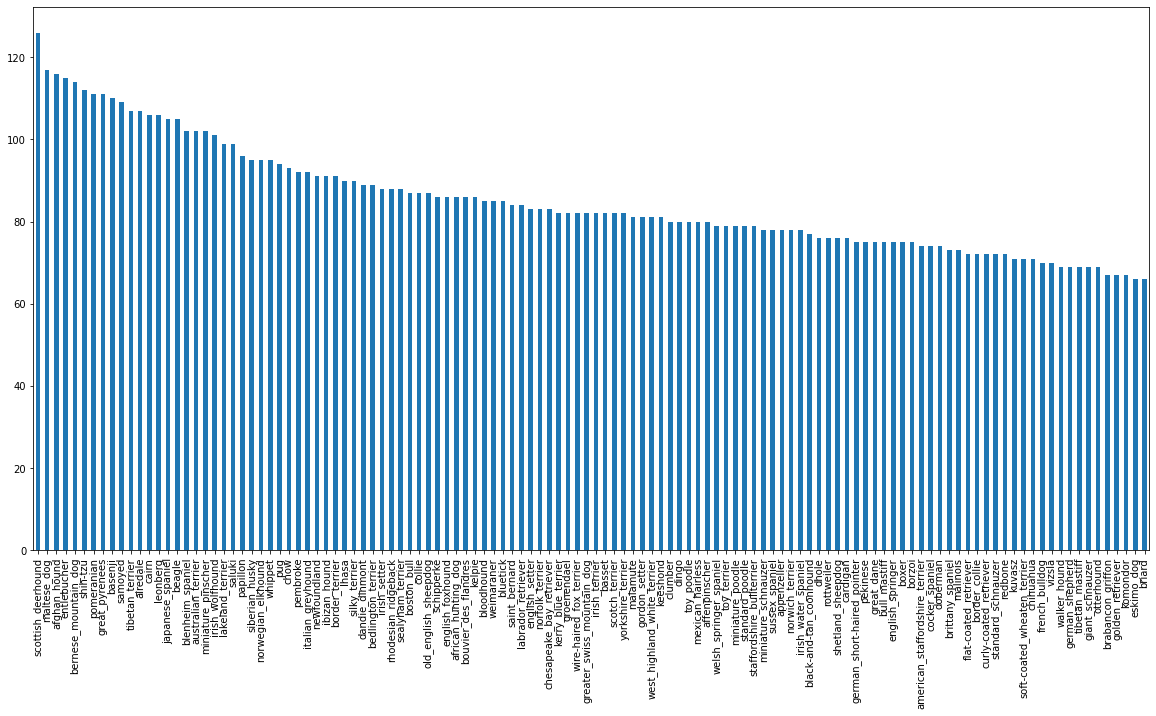

In [8]:
#Viewing the data distribution
df["breed"].value_counts().plot.bar(figsize=(20,10))

### Preprocessing the Data

In [9]:
# Geting the list of training filenames
filenames = ['/content/train/' + fname +'.jpg' for fname in df["id"]]
print(filenames[:10])
if len(os.listdir('/content/train')) == len(filenames):
  print("Amount of files match!")
else:
  print("Amount of files don't match!")

['/content/train/000bec180eb18c7604dcecc8fe0dba07.jpg', '/content/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg', '/content/train/001cdf01b096e06d78e9e5112d419397.jpg', '/content/train/00214f311d5d2247d5dfe4fe24b2303d.jpg', '/content/train/0021f9ceb3235effd7fcde7f7538ed62.jpg', '/content/train/002211c81b498ef88e1b40b9abf84e1d.jpg', '/content/train/00290d3e1fdd27226ba27a8ce248ce85.jpg', '/content/train/002a283a315af96eaea0e28e7163b21b.jpg', '/content/train/003df8b8a8b05244b1d920bb6cf451f9.jpg', '/content/train/0042188c895a2f14ef64a918ed9c7b64.jpg']
Amount of files match!


In [10]:
# Getting the unique labels and the list of breeds
labels = list(df["breed"])
unique_breeds = np.unique(labels)
print("Labels:",labels[:10],"\n")
print("Unique Breads:",unique_breeds[:10])

Labels: ['boston_bull', 'dingo', 'pekinese', 'bluetick', 'golden_retriever', 'bedlington_terrier', 'bedlington_terrier', 'borzoi', 'basenji', 'scottish_deerhound'] 

Unique Breads: ['affenpinscher' 'afghan_hound' 'african_hunting_dog' 'airedale'
 'american_staffordshire_terrier' 'appenzeller' 'australian_terrier'
 'basenji' 'basset' 'beagle']


> One Hot Encoding the Labels

In [11]:
lbl=LabelEncoder()
labels=lbl.fit_transform(labels)

In [12]:
labels = to_categorical(labels)
print("Number of unique labels:",len(labels[0]))
labels[0]

Number of unique labels: 120


array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0.], dtype=float32)

In [13]:
X = filenames
y = labels
len(X)

10222

> Splitting the data into Training and Validation

In [14]:
NUM_IMAGES = 1000 #@param {type:"slider", min:1000, max:10222, step:2}

In [15]:
X_train, X_val, y_train, y_val = train_test_split(X[:NUM_IMAGES],
                                                  y[:NUM_IMAGES],
                                                  test_size=0.2,
                                                  random_state=42)

len(X_train), len(X_val), len(y_train), len(y_val) 

(800, 200, 800, 200)

### ***Getting the Data Ready in Batches***

We will define some functions to process the images and to put the data in Batches.

In [16]:
# Define image size
IMG_SIZE = 224

# Create a function for preprocessing images
def process_image(image_path, img_size=IMG_SIZE):
  """
  Takes an image file path and turns the image into a Tensor.
  """
  # Read in an image file
  image = tf.io.read_file(image_path)
  # Turn the jpeg image into numerical Tensor with 3 colour channels (Red, Green, Blue)
  image = tf.image.decode_jpeg(image, channels=3)
  # Convert the colour channel values from 0-255 to 0-1 values
  image = tf.image.convert_image_dtype(image, tf.float32)
  # Resize the image to our desired value (224, 224)
  image = tf.image.resize(image, size=[IMG_SIZE, IMG_SIZE])

  return image

In [17]:
# Create a simple function to return a tuple (image, label)
def get_image_label(image_path, label):
  """
  Takes an image file path name and the assosciated label,
  processes the image and reutrns a tuple of (image, label).
  """
  image = process_image(image_path)
  return image, label

In [18]:
# Define the batch size
BATCH_SIZE = 32

# Create a function to turn data into batches
def create_data_batches(X, y=None, batch_size=BATCH_SIZE, valid_data=False, test_data=False):
  """
  Creates batches of data out of image (X) and label (y) pairs.
  Shuffles the data if it's training data but doesn't shuffle if it's validation data.
  Also accepts test data as input (no labels).
  """
  # If the data is a test dataset
  if test_data:
    print("Creating test data batches...")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X))) # only filepaths (no labels)
    data_batch = data.map(process_image).batch(BATCH_SIZE)
    return data_batch
  
  # If the data is a valid dataset
  elif valid_data:
    print("Creating validation data batches...")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X), # filepaths
                                               tf.constant(y))) # labels
    data_batch = data.map(get_image_label).batch(BATCH_SIZE)
    return data_batch

  else:
    print("Creating training data batches...")
    # Turn filepaths and labels into Tensors
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X),
                                               tf.constant(y)))
    # Shuffling pathnames and labels before mapping image processor function is faster than shuffling images
    data = data.shuffle(buffer_size=len(X))

    # Create (image, label) tuples (this also turns the image path into a preprocessed image)
    data = data.map(get_image_label)

    # Turn the training data into batches
    data_batch = data.batch(BATCH_SIZE)
  return data_batch

In [19]:
# Create training and validation data batches
train_data = create_data_batches(X_train, y_train)
val_data = create_data_batches(X_val, y_val, valid_data=True)

Creating training data batches...
Creating validation data batches...


In [20]:
# Check out the different attributes of our data batches
train_data.element_spec, val_data.element_spec

((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.float32, name=None)),
 (TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.float32, name=None)))

In [21]:
# Create a function for viewing images in a data batch
def show_25_images(images, labels):
  """
  Displays a plot of 25 images and their labels from a data batch.
  """
  # Setup the figure
  plt.figure(figsize=(15, 15))
  # Loop through 25 (for displaying 25 images)
  for i in range(25):
    # Create subplots (5 rows, 5 columns)
    ax = plt.subplot(5, 5, i+1)
    # Display an image 
    plt.imshow(images[i])
    # Add the image label as the title
    plt.title(unique_breeds[labels[i].argmax()])
    # Turn the grid lines off
    plt.axis("off")

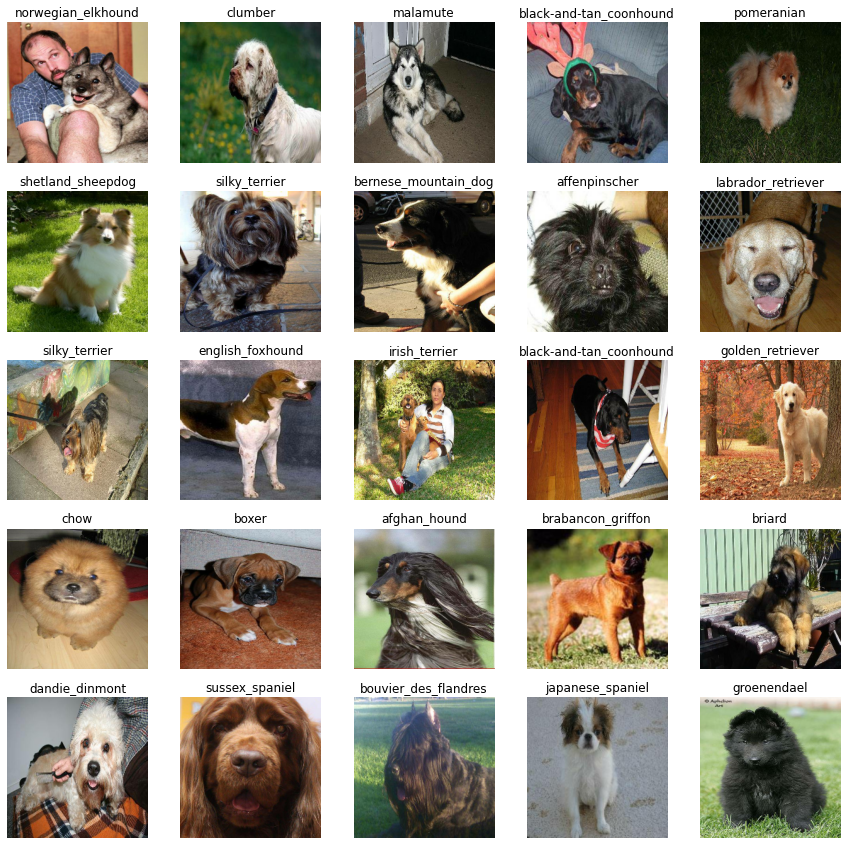

In [22]:
# Now let's visualize the data in a training batch
train_images, train_labels = next(train_data.as_numpy_iterator())
show_25_images(train_images, train_labels)

### Creating the Model
We will be using the imagenet-mobilenet_v2_130_224-classification

In [23]:
INPUT_SHAPE = [None, IMG_SIZE, IMG_SIZE, 3]
OUTPUT_SHAPE = len(unique_breeds)
MODEL_URL = "https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4"

In [24]:
# Setup the model layers
model = tf.keras.Sequential([
    hub.KerasLayer(MODEL_URL), # Layer 1 (input layer)
    tf.keras.layers.Dense(units=OUTPUT_SHAPE,activation="softmax") # Layer 2 (output layer)
  ])

# Compile the model
model.compile(
      loss=tf.keras.losses.CategoricalCrossentropy(),
      optimizer=tf.keras.optimizers.Adam(),
      metrics=["accuracy"]
  )

# Build the model
model.build(INPUT_SHAPE)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1001)              5432713   
_________________________________________________________________
dense (Dense)                (None, 120)               120240    
Total params: 5,552,953
Trainable params: 120,240
Non-trainable params: 5,432,713
_________________________________________________________________


In [25]:
# Load TensorBoard notebook extension
%load_ext tensorboard

In [26]:
!mkdir ./logs
# Create a function to build a TensorBoard callback
def create_tensorboard_callback():
  # Create a log directory for storing TensorBoard logs
  logdir = os.path.join("./logs",
                        # Make it so the logs get tracked whenever we run an experiment
                        datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
  return tf.keras.callbacks.TensorBoard(logdir)

In [27]:
# Create early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",
                                                  patience=3)

In [28]:
NUM_EPOCHS = 100
tensorboard = create_tensorboard_callback()

# Fit the model to the data passing it the callbacks we created
model.fit(x=train_data,
          epochs=NUM_EPOCHS,
          validation_data=val_data,
          validation_freq=1,
          callbacks=[tensorboard, early_stopping])

Epoch 1/100
25/25 [==============================] - 14s 167ms/step - loss: 5.0880 - accuracy: 0.0444 - val_loss: 3.3375 - val_accuracy: 0.2650
Epoch 2/100
25/25 [==============================] - 3s 136ms/step - loss: 1.8998 - accuracy: 0.6248 - val_loss: 2.0964 - val_accuracy: 0.5450
Epoch 3/100
25/25 [==============================] - 3s 136ms/step - loss: 0.6263 - accuracy: 0.9349 - val_loss: 1.5671 - val_accuracy: 0.6100
Epoch 4/100
25/25 [==============================] - 3s 137ms/step - loss: 0.2762 - accuracy: 0.9885 - val_loss: 1.4222 - val_accuracy: 0.6500
Epoch 5/100
25/25 [==============================] - 3s 137ms/step - loss: 0.1550 - accuracy: 0.9961 - val_loss: 1.3590 - val_accuracy: 0.6650
Epoch 6/100
25/25 [==============================] - 3s 139ms/step - loss: 0.0996 - accuracy: 0.9992 - val_loss: 1.3106 - val_accuracy: 0.6600
Epoch 7/100
25/25 [==============================] - 3s 137ms/step - loss: 0.0798 - accuracy: 1.0000 - val_loss: 1.2893 - val_accuracy: 0.665

### Viewing the performance of our Model
Clearly our model is currently overfitting but training on the full dataset (using more data) might fix the problem.

In [29]:
#Uncomment below to view the Tensorboard
#%tensorboard --logdir /content/logs

In [30]:
predictions = model.predict(val_data, verbose=1)
predictions

7/7 [==============================] - 1s 103ms/step


array([[7.88245175e-04, 6.07300135e-05, 8.32261983e-04, ...,
        3.39064485e-04, 7.02960006e-06, 2.12588557e-03],
       [1.54947524e-03, 5.50809957e-04, 1.10591175e-02, ...,
        1.16574601e-03, 3.52012087e-03, 4.73945183e-05],
       [1.03016275e-04, 8.51789548e-04, 6.07939844e-04, ...,
        2.70989753e-04, 3.39646998e-04, 1.10684882e-03],
       ...,
       [6.38945312e-06, 1.70055719e-05, 4.64500263e-05, ...,
        5.33433877e-06, 1.67140370e-05, 2.73358764e-05],
       [1.09355140e-03, 3.25746878e-05, 4.78736511e-05, ...,
        8.16453103e-05, 3.30155744e-05, 3.50291748e-03],
       [3.53586860e-04, 7.70681618e-06, 6.27054134e-04, ...,
        5.62358787e-03, 6.33645337e-04, 3.95353209e-06]], dtype=float32)

In [31]:
# Turn prediction probabilities into their respective label (easier to understand)
def get_pred_label(prediction_probabilities):
  """
  Turns an array of prediction probabilities into a label.
  """
  return unique_breeds[np.argmax(prediction_probabilities)]

# Get a predicted label based on an array of prediction probabilities
pred_label = get_pred_label(predictions[81])
pred_label

'dingo'

In [32]:
# Create a function to unbatch a batch dataset
def unbatchify(data):
  """
  Takes a batched dataset of (image, label) Tensors and reutrns separate arrays
  of images and labels.
  """
  images = []
  labels = []
  # Loop through unbatched data
  for image, label in data.unbatch().as_numpy_iterator():
    images.append(image)
    labels.append(unique_breeds[np.argmax(label)])
  return images, labels

# Unbatchify the validation data
val_images, val_labels = unbatchify(val_data)
val_images[0], val_labels[0]

(array([[[0.29599646, 0.43284872, 0.3056691 ],
         [0.26635826, 0.32996926, 0.22846507],
         [0.31428418, 0.2770141 , 0.22934894],
         ...,
         [0.77614343, 0.82320225, 0.8101595 ],
         [0.81291157, 0.8285351 , 0.8406944 ],
         [0.8209297 , 0.8263737 , 0.8423668 ]],
 
        [[0.2344871 , 0.31603682, 0.19543913],
         [0.3414841 , 0.36560842, 0.27241898],
         [0.45016077, 0.40117094, 0.33964607],
         ...,
         [0.7663987 , 0.8134138 , 0.81350833],
         [0.7304248 , 0.75012016, 0.76590735],
         [0.74518913, 0.76002574, 0.7830809 ]],
 
        [[0.30157745, 0.3082587 , 0.21018331],
         [0.2905954 , 0.27066195, 0.18401104],
         [0.4138316 , 0.36170745, 0.2964005 ],
         ...,
         [0.79871625, 0.8418535 , 0.8606443 ],
         [0.7957738 , 0.82859945, 0.8605655 ],
         [0.75181633, 0.77904975, 0.8155256 ]],
 
        ...,
 
        [[0.9746779 , 0.9878955 , 0.9342279 ],
         [0.99153054, 0.99772066, 0.94278

In [33]:
def plot_pred(prediction_probabilities, labels, images, n=1):
  """
  View the prediction, ground truth and image for sample n
  """
  pred_prob, true_label, image = prediction_probabilities[n], labels[n], images[n]

  # Get the pred label
  pred_label = get_pred_label(pred_prob)

  # Plot image & remove ticks
  plt.imshow(image)
  plt.xticks([])
  plt.yticks([])

  # Change the colour of the title depending on if the prediction is right or wrong
  if pred_label == true_label:
    color = "green"
  else:
    color = "red"
  
  # Change plot title to be predicted, probability of prediction and truth label
  plt.title("{} {:2.0f}% {}".format(pred_label,
                                    np.max(pred_prob)*100,
                                    true_label),
                                    color=color)

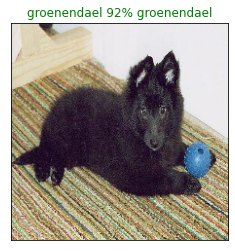

In [34]:
plot_pred(prediction_probabilities=predictions,
          labels=val_labels,
          images=val_images,
          n=77)

### Saving our Model

In [35]:
# Create a function to save a model
!mkdir ./models
def save_model(model, suffix=None):
  """
  Saves a given model in a models directory and appends a suffix (string).
  """
  # Create a model directory pathname with current time
  modeldir = os.path.join("./models",
                          datetime.datetime.now().strftime("%Y%m%d-%H%M%s"))
  model_path = modeldir + "-" + suffix + ".h5" # save format of model
  print(f"Saving model to: {model_path}...")
  model.save(model_path)
  return model_path

In [36]:
# Create a function to load a trained model
def load_model(model_path):
  """
  Loads a saved model from a specified path.
  """
  print(f"Loading saved model from: {model_path}")
  model = tf.keras.models.load_model(model_path, 
                                     custom_objects={"KerasLayer":hub.KerasLayer})
  return model

In [37]:
# Save our model trained on 1000 images
#save_model(model, suffix="1000-images-mobilenetv2-Adam")

In [38]:
# Load a trained model
#loaded_1000_image_model = load_model('PATH') #Provide the PATH

### Training on the Full Dataset

In [39]:
len(X), len(y)

(10222, 10222)

In [40]:
# Create a data batch with the full data set
full_data = create_data_batches(X, y)

Creating training data batches...


In [41]:
# Setup the model layers
Final_model = tf.keras.Sequential([
    hub.KerasLayer(MODEL_URL), # Layer 1 (input layer)
    tf.keras.layers.Dense(units=OUTPUT_SHAPE,activation="softmax") # Layer 2 (output layer)
  ])

# Compile the model
Final_model.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["accuracy"]
  )

# Build the model
Final_model.build(INPUT_SHAPE)
Final_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 1001)              5432713   
_________________________________________________________________
dense_1 (Dense)              (None, 120)               120240    
Total params: 5,552,953
Trainable params: 120,240
Non-trainable params: 5,432,713
_________________________________________________________________


In [42]:
# Create full model callbacks
Final_model_tensorboard = create_tensorboard_callback()
# No validation set when training on all the data, so we can't monitor validation accuracy
Final_model_early_stopping = tf.keras.callbacks.EarlyStopping(monitor="accuracy",
                                                             patience=3)

In [43]:
# Fit the full model to the full data
NUM_EPOCHS=12
Final_model.fit(x=full_data,
               epochs=NUM_EPOCHS,
               callbacks=[Final_model_tensorboard, Final_model_early_stopping])

Epoch 1/100
320/320 [==============================] - 44s 127ms/step - loss: 2.3924 - accuracy: 0.4892
Epoch 2/100
320/320 [==============================] - 40s 124ms/step - loss: 0.3810 - accuracy: 0.8917
Epoch 3/100
320/320 [==============================] - 39s 123ms/step - loss: 0.2254 - accuracy: 0.9420
Epoch 4/100
320/320 [==============================] - 39s 123ms/step - loss: 0.1381 - accuracy: 0.9696
Epoch 5/100
320/320 [==============================] - 39s 123ms/step - loss: 0.1004 - accuracy: 0.9816
Epoch 6/100
320/320 [==============================] - 39s 123ms/step - loss: 0.0708 - accuracy: 0.9885
Epoch 7/100
320/320 [==============================] - 39s 122ms/step - loss: 0.0554 - accuracy: 0.9921
Epoch 8/100
320/320 [==============================] - 39s 123ms/step - loss: 0.0392 - accuracy: 0.9967
Epoch 9/100
320/320 [==============================] - 39s 123ms/step - loss: 0.0367 - accuracy: 0.9956
Epoch 10/100
320/320 [==============================] - 39s 123m

In [44]:
save_model(Final_model, suffix="full-dataset-mobilenetv2-Adam")

Saving model to: ./models/20210123-04511611377495-full-dataset-mobilenetv2-Adam.h5...


'./models/20210123-04511611377495-full-dataset-mobilenetv2-Adam.h5'

### Creating the submission

In [45]:
# Load test image filenames
test_path = "/content/test/"
test_filenames = [test_path + fname for fname in os.listdir(test_path)]
print(len(test_filenames))
test_filenames[:10]


10357


['/content/test/57561c9498cf19caed3e4b2b04367116.jpg',
 '/content/test/49a13d472605473ef3f9b2e4f638d700.jpg',
 '/content/test/7b2e25dfb12d69566e59246970f161b1.jpg',
 '/content/test/e5b14b20ee8ac070bf5cea3b640f3dde.jpg',
 '/content/test/1929a4008c9672f934e3934ddd290dd4.jpg',
 '/content/test/8039f8c115eeaaaa324820bb49640fcd.jpg',
 '/content/test/852e1b3c162e231c41a5476368535d69.jpg',
 '/content/test/4c3fb315701d8760182459ae74e1a314.jpg',
 '/content/test/cd9647853458c4fd67e4057379d5e4ca.jpg',
 '/content/test/a6f7a3bad09db1ac741a7dbb765482f2.jpg']

In [46]:
# Create test data batch
test_data = create_data_batches(test_filenames, test_data=True)

Creating test data batches...


In [47]:
test_data

<BatchDataset shapes: (None, 224, 224, 3), types: tf.float32>

In [48]:
# Make predictions on test data batch using the loaded full model
test_predictions = Final_model.predict(test_data,verbose=1)

324/324 [==============================] - 40s 122ms/step


In [ ]:
# Create a pandas DataFrame with empty columns
preds_df = pd.DataFrame(columns=["id"] + list(unique_breeds))
preds_df.head()

In [ ]:
# Append test image ID's to predictions DataFrame
test_ids = [os.path.splitext(path)[0] for path in os.listdir(test_path)]
preds_df["id"] = test_ids
preds_df.head()

In [ ]:
# Add the prediction probabilities to each dog breed column
preds_df[list(unique_breeds)] = test_predictions
preds_df.head()

In [53]:
# Save our predictions dataframe to CSV for submission to Kaggle
preds_df.to_csv("./full_model_predictions_submission.csv",index=False)